In [1]:
# clustertools
import clustertools as ctools
import galpy as gp
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

### Functions used for analysis

In [2]:
# this funciton parses through a data file and keeps stars with mass lower than 1.1 solar mass (returns cluster in cluster frame of referance, in pc)
def stars_only(data_file):
    
    lost_cluster = False                                          # set a variable so that can break if lost cluster
    cluster = ctools.analysis.cluster.sub_cluster(data_file,mmax=1.1)
    cluster.find_centre()

    if cluster.mtot == 0:
        print('Lost Cluster')
        lost_cluster = True
    else:
        lost_cluster = False
        
    cluster.to_centre()
    cluster.to_pckms()
    return cluster, lost_cluster 

In [3]:
# this function returns values of tidal radius, half mass radius, mass(inside tidal radius), galactic radii, and a list of [x,y,z,vx,vy,vx] for a given timestep
def cluster_info(smf,star_data):
    
    # set the correct potential for use
    if smf == 0.001:
        pot_smf = pot_smf01
    elif smf == 0.01:
        pot_smf = pot_smf1
    elif smf == 0.03:
        pot_smf = pot_smf3
    elif smf == 0.1:
        pot_smf = pot_smf10
    
    # compute the tidal radius
    rtide = ctools.rtidal(star_data,pot_smf,ro=8.,vo=220)
    
    # define the new cluster to be all stars with radi inside the tidal radius
    new_cluster = ctools.analysis.cluster.sub_cluster(star_data,rmax=rtide)
    
    if len(new_cluster.x) == 0:
        print('Lost Cluster')
        lost_cluster = True
        return 0, 0, 0, 0, 0, lost_cluster
    else:
        lost_cluster = False
        
    
    # compute the half mass radius
    #new_hmr = 0.145 * rtide
    new_hmr = new_cluster.rm
    
    # compute the new cluster mass (all stars equal to 1, thus len of radius array)
    new_mass = new_cluster.mtot
    
    # put cluster pack to galactic referance frame
    new_cluster.to_galaxy()
    
    # get galactic coordinates
    new_x, new_y, new_z, new_vx, new_vy, new_vz =  ctools.analysis.functions.find_centre(new_cluster)
    new_coords = [new_x,new_y,new_z,new_vx,new_vy,new_vz]
    new_r = np.sqrt(new_x**2 + new_y**2 + new_z**2)
    
    return rtide, new_hmr, new_mass, new_r, new_coords, lost_cluster

In [4]:
# this function analyzes the time evolution of a simulation, for both the control and the subhalo simulation
def analyze_evolution(smf, kpc, sub_fname, ctrl_fname):
    
    # define lists to hold values
    t = []
    Sub_rtide, Sub_hmr, Sub_mass, Sub_r, Sub_x, Sub_y, Sub_z, Sub_vx, Sub_vy, Sub_vz = [], [], [], [], [], [], [], [], [], []
    Ctrl_rtide, Ctrl_hmr, Ctrl_mass, Ctrl_r, Ctrl_x, Ctrl_y, Ctrl_z, Ctrl_vx, Ctrl_vy, Ctrl_vz = [], [], [], [], [], [], [], [], [], []
    
    # define counter for time
    t_step = 0
    
    # this is to find where the function breaks
    hold =[]
    
    # import the data
    subsim_data = ctools.load_cluster('gyrfalcon',filename=sub_fname)
    ctrl_data = ctools.load_cluster('gyrfalcon',filename=ctrl_fname)
    
    # loop over the evolution of the cluster
    while subsim_data.ntot != 0 or ctrl_data.ntot != 0:
        
        # get new stars only as cluster
        sub_cluster, lost_cluster1 = stars_only(subsim_data)
        control_cluster, lost_cluster2 = stars_only(ctrl_data)
        
        
        
        """#plot cluster
        plt.figure(figsize=[10,8])
        ctools.starplot(sub_cluster,coords='xy',xlim=[-2000,2000],ylim=[-2000,2000])
        plt.savefig('%s.png' % str(t_step).zfill(5))
        plt.show()
        plt.close()"""
        
        
        
        # get data from subhalo-simulation timestep
        sub_rtide, sub_hmr, sub_mass, sub_r, sub_coords, lost_cluster = cluster_info(smf, sub_cluster)
        
        # break if cluster has been lost
        if lost_cluster is True:
            print('Lost Cluster @ timestep: ', str(t_step))
            
            # create lists to return
            subsim_evo = [Sub_rtide,Sub_hmr,Sub_mass,Sub_r,Sub_x,Sub_y,Sub_z,Sub_vx,Sub_vy,Sub_vz]
            control_evo = [Ctrl_rtide,Ctrl_hmr,Ctrl_mass,Ctrl_r,Ctrl_x,Ctrl_y,Ctrl_z,Ctrl_vx,Ctrl_vy,Ctrl_vz]

            # save the files for referance later
            np.savetxt('smf'+str(smf)+'_s'+str(kpc),subsim_evo)
            np.savetxt('smf'+str(smf)+'_c'+str(kpc),control_evo)
            
            break
        else:
            lost_cluster = False
        
        # get data from control-simulation timestep
        ctrl_rtide, ctrl_hmr, ctrl_mass, ctrl_r, ctrl_coords, lost_cluster = cluster_info(smf, control_cluster)
        
        # break if cluster has been lost
        if lost_cluster is True:
            print('Lost Cluster @ timestep: ', str(t_step))
            
            # create lists to return
            subsim_evo = [Sub_rtide,Sub_hmr,Sub_mass,Sub_r,Sub_x,Sub_y,Sub_z,Sub_vx,Sub_vy,Sub_vz]
            control_evo = [Ctrl_rtide,Ctrl_hmr,Ctrl_mass,Ctrl_r,Ctrl_x,Ctrl_y,Ctrl_z,Ctrl_vx,Ctrl_vy,Ctrl_vz]

            # save the files for referance later
            np.savetxt('smf'+str(smf)+'_s'+str(kpc),subsim_evo)
            np.savetxt('smf'+str(smf)+'_c'+str(kpc),control_evo)
            
            break
        else:
            lost_cluster = False
        
        # break if cluster has been lost
        if lost_cluster1 is True or lost_cluster2 is True:
            print('Lost Cluster @ timestep: ', str(t_step))
            
            # create lists to return
            subsim_evo = [Sub_rtide,Sub_hmr,Sub_mass,Sub_r,Sub_x,Sub_y,Sub_z,Sub_vx,Sub_vy,Sub_vz]
            control_evo = [Ctrl_rtide,Ctrl_hmr,Ctrl_mass,Ctrl_r,Ctrl_x,Ctrl_y,Ctrl_z,Ctrl_vx,Ctrl_vy,Ctrl_vz]

            # save the files for referance later
            np.savetxt('smf'+str(smf)+'_s'+str(kpc),subsim_evo)
            np.savetxt('smf'+str(smf)+'_c'+str(kpc),control_evo)
            
            break
        else:
            lost_cluster1 = lost_cluster2 = False
        
        # append timestep data to lists
        t.append(t_step)
        
        Sub_rtide.append(sub_rtide)
        Sub_hmr.append(sub_hmr)
        Sub_mass.append(sub_mass)
        Sub_r.append(sub_r)
        Sub_x.append(sub_coords[0])
        Sub_y.append(sub_coords[1])
        Sub_z.append(sub_coords[2])
        Sub_vx.append(sub_coords[3])
        Sub_vy.append(sub_coords[4])
        Sub_vz.append(sub_coords[5])
        
        Ctrl_rtide.append(ctrl_rtide)
        Ctrl_hmr.append(ctrl_hmr)
        Ctrl_mass.append(ctrl_mass)
        Ctrl_r.append(ctrl_r)
        Ctrl_x.append(ctrl_coords[0])
        Ctrl_y.append(ctrl_coords[1])
        Ctrl_z.append(ctrl_coords[2])
        Ctrl_vx.append(ctrl_coords[3])
        Ctrl_vy.append(ctrl_coords[4])
        Ctrl_vz.append(ctrl_coords[5])
        
        # advance cluster to next timestep
        subsim_data = ctools.analysis.load.advance_cluster(subsim_data)
        ctrl_data = ctools.analysis.load.advance_cluster(ctrl_data)
        
        # save timestep
        t_step += 1
        
        #print(t_step)
        
    # create lists to return
    subsim_evo = [Sub_rtide,Sub_hmr,Sub_mass,Sub_r,Sub_x,Sub_y,Sub_z,Sub_vx,Sub_vy,Sub_vz]
    control_evo = [Ctrl_rtide,Ctrl_hmr,Ctrl_mass,Ctrl_r,Ctrl_x,Ctrl_y,Ctrl_z,Ctrl_vx,Ctrl_vy,Ctrl_vz]
    
    # save the files for referance later
    np.savetxt('smf'+str(smf)+'_s'+str(kpc),subsim_evo)
    np.savetxt('smf'+str(smf)+'_c'+str(kpc),control_evo)
    
    #return subsim_data, control_data

### Potentials to be used in analysis

In [5]:
# Create potential instances to input into galpy.rtide()
pot_smf01 = gp.potential.LogarithmicHaloPotential(amp=1.0 - 0.001, ro=8., vo=220.)
pot_smf1 = gp.potential.LogarithmicHaloPotential(amp=1.0 - 0.01, ro=8., vo=220.)
pot_smf3 = gp.potential.LogarithmicHaloPotential(amp=1.0 - 0.03, ro=8., vo=220.)
pot_smf10 = gp.potential.LogarithmicHaloPotential(amp=1.0 - 0.1, ro=8., vo=220.)

### Full-suite raw data filename creation

In [6]:
# create arrays of filenames to loop through for analysis
sub_fnames = []
ctrl_fnames = []
smf_ranges1 = ['smf01','smf1','smf3','smf10']
smf_ranges2 = ['0smf','1smf','3smf','10smf']
kpc_ranges = [5,10,20,40,60]
for i in range(4):
    sub_temp = []
    ctrl_temp = []
    for j in range(5):
        sub_filename = smf_ranges1[i] + '/ptrb_EV_' + str(kpc_ranges[j]) + 'kpc_' + str(smf_ranges2[i]) + '_mspec_1000stars.dat'
        ctrl_filename = smf_ranges1[i] + '/base_EV_' + str(kpc_ranges[j]) + 'kpc_' + str(smf_ranges2[i]) + '_mspec_1000stars.dat'   
        sub_temp.append(sub_filename)
        ctrl_temp.append(ctrl_filename)
    sub_fnames.append(sub_temp)
    ctrl_fnames.append(ctrl_temp)

### Single Suite analysis data creation

In [8]:
# define a list of the smfs
smfs = [0.001,0.01,0.03,0.1]
kpc_ranges = [5,10,20,40,60]

t0 = time()
for i in range(4):
    analyze_evolution(smfs[0], kpc_ranges[i+1], sub_fnames[0][i+1], ctrl_fnames[0][i+1])
    print('Finished ' + smf_ranges1[0] + ' ' + str(kpc_ranges[i+1]) + 'kpc')
print('1smf analysis took: ',time() - t0,' seconds')

1smf analysis took:  18.610565423965454  seconds


### Full suite import of analysis data

In [7]:
# for referance
smfs = [0.001,0.01,0.03,0.1]

# below arrays are for the kmax=8 resolution
asub_k8_fnames = []
actrl_k8_fnames = []

kpc_ranges = [5,10,20,40,60]
for i in range(4):
    # create temperary lists so that the final product is array like
    asub_k8_temp = []
    actrl_k8_temp = []
    for j in range(5):
        
        # write the filenames for each case
        asub_k8_filename = 'kmax8_analyzed_data/smf' + str(smfs[i]) + '_s' + str(kpc_ranges[j])
        actrl_k8_filename = 'kmax8_analyzed_data/smf' + str(smfs[i]) + '_c' + str(kpc_ranges[j])
        
        # append to temp list for array like nature
        asub_k8_temp.append(asub_k8_filename)
        actrl_k8_temp.append(actrl_k8_filename)
    
    # append sub list to parent list for each kpcs grouping
    asub_k8_fnames.append(asub_k8_temp)
    actrl_k8_fnames.append(actrl_k8_temp)

### Full suite plot

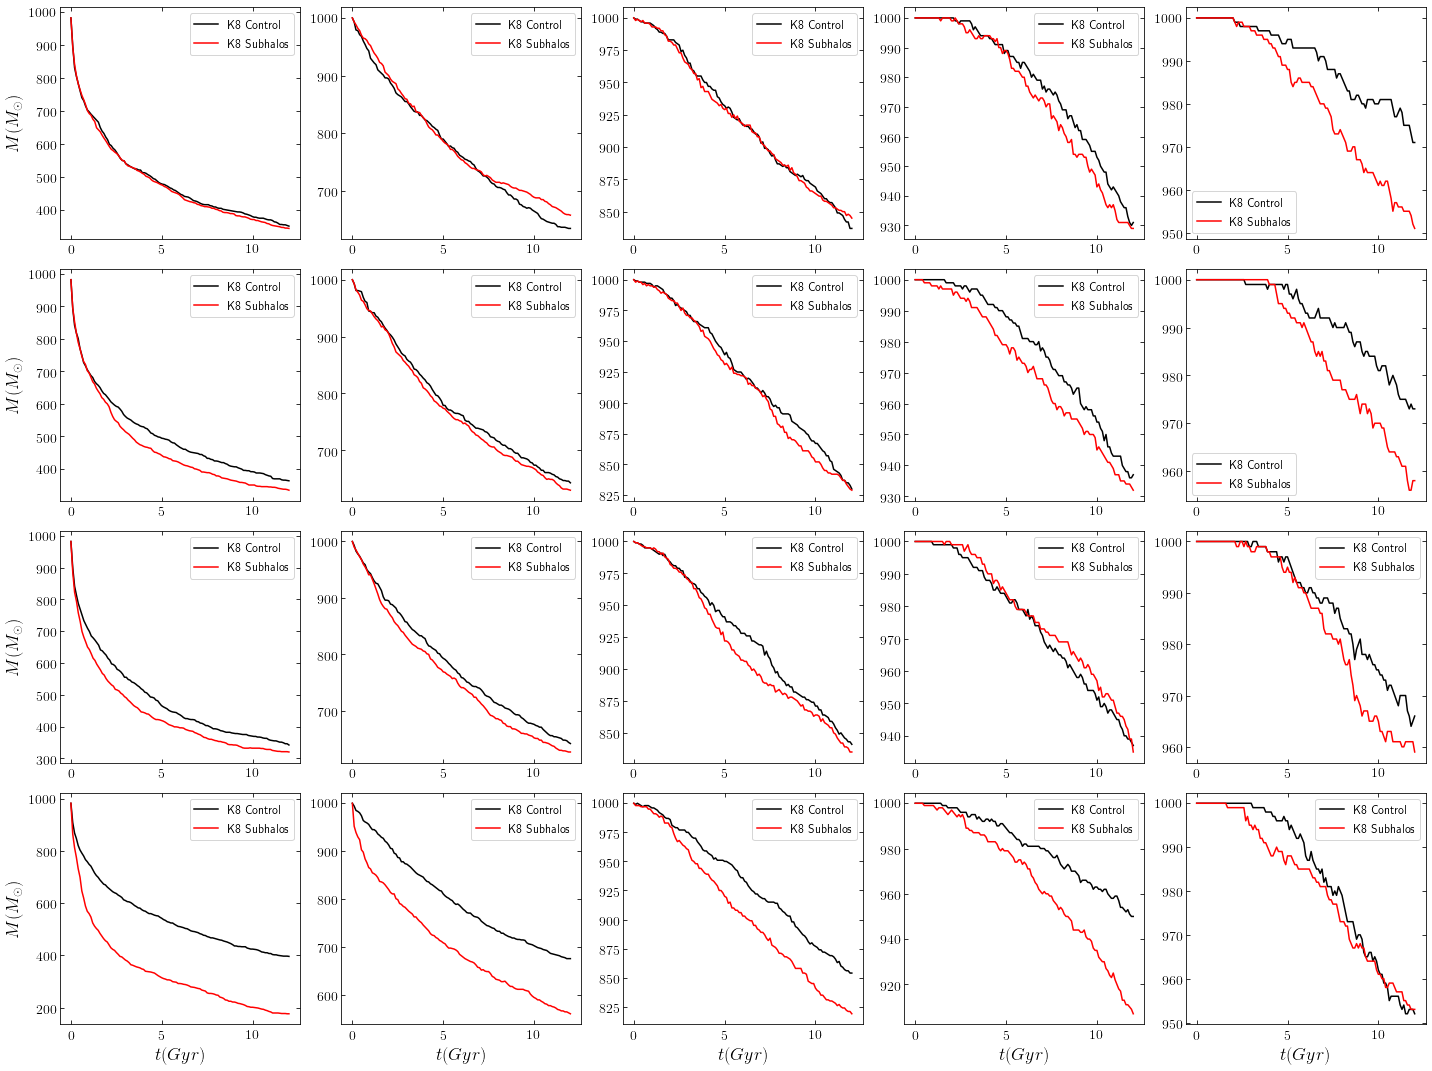

In [32]:
# time domain
t = np.linspace(0,12,len(np.loadtxt(actrl_k8_fnames[1][0])[2]))

# create a loop that subplots all data
plt.figure(figsize=[20,15])

count = 1
for i in range(4):
    for j in range(5):
        if j == 0 and i != 3:
            plt.subplot(4,5,count)
            #plt.plot(np.loadtxt(actrl_sstep_fnames[i][j])[2],label='Small Step Control')
            #plt.plot(np.loadtxt(asub_sstep_fnames[i][j])[2],label='Small Step Subhalos')
            plt.plot(np.linspace(0,12,len(np.loadtxt(actrl_k8_fnames[i][j])[2])),np.loadtxt(actrl_k8_fnames[i][j])[2],label='K8 Control',color='black')
            plt.plot(np.linspace(0,12,len(np.loadtxt(actrl_k8_fnames[i][j])[2])),np.loadtxt(asub_k8_fnames[i][j])[2],label='K8 Subhalos',color='red')
            plt.ylabel('$M (M_{\odot})$')
            plt.legend()
            count+=1
        elif j == 0 and i == 3:
            plt.subplot(4,5,count)
            #plt.plot(np.loadtxt(actrl_sstep_fnames[i][j])[2],label='Small Step Control')
            #plt.plot(np.loadtxt(asub_sstep_fnames[i][j])[2],label='Small Step Subhalos')
            plt.plot(np.linspace(0,12,len(np.loadtxt(actrl_k8_fnames[i][j])[2])),np.loadtxt(actrl_k8_fnames[i][j])[2],label='K8 Control',color='black')
            plt.plot(np.linspace(0,12,len(np.loadtxt(actrl_k8_fnames[i][j])[2])),np.loadtxt(asub_k8_fnames[i][j])[2],label='K8 Subhalos',color='red')
            plt.xlabel('$t (Gyr)$')
            plt.ylabel('$M (M_{\odot})$')
            plt.legend()
            count+=1
        elif i == 3:
            plt.subplot(4,5,count)
            #plt.plot(np.loadtxt(actrl_sstep_fnames[i][j])[2],label='Small Step Control')
            #plt.plot(np.loadtxt(asub_sstep_fnames[i][j])[2],label='Small Step Subhalos')
            plt.plot(np.linspace(0,12,len(np.loadtxt(actrl_k8_fnames[i][j])[2])),np.loadtxt(actrl_k8_fnames[i][j])[2],label='K8 Control',color='black')
            plt.plot(np.linspace(0,12,len(np.loadtxt(actrl_k8_fnames[i][j])[2])),np.loadtxt(asub_k8_fnames[i][j])[2],label='K8 Subhalos',color='red')
            plt.xlabel('$t (Gyr)$')
            plt.legend()
            count+=1
        else:
            plt.subplot(4,5,count)
            #plt.plot(np.loadtxt(actrl_sstep_fnames[i][j])[2],label='Small Step Control')
            #plt.plot(np.loadtxt(asub_sstep_fnames[i][j])[2],label='Small Step Subhalos')
            plt.plot(np.linspace(0,12,len(np.loadtxt(actrl_k8_fnames[i][j])[2])),np.loadtxt(actrl_k8_fnames[i][j])[2],label='K8 Control',color='black')
            plt.plot(np.linspace(0,12,len(np.loadtxt(actrl_k8_fnames[i][j])[2])),np.loadtxt(asub_k8_fnames[i][j])[2],label='K8 Subhalos',color='red')
            plt.legend()
            count+=1
        
plt.tight_layout()
plt.savefig('1000star_mloss')

# Time Resolution Study

### Raw data filename creation

In [11]:
# create arrays of filenames to loop through for analysis
#1st IC group
k10_sub_fnames = []
k10_ctrl_fnames = []
k12_sub_fnames = []
k12_ctrl_fnames = []
k13_sub_fnames = []
k13_ctrl_fnames = []
k14_sub_fnames = []
k14_ctrl_fnames = []

k12tp_sub_fnames = []
k12tp_ctrl_fnames = []

#second IC group
k10_2_sub_fnames = []
k10_2_ctrl_fnames = []
k12_2_sub_fnames = []
k12_2_ctrl_fnames = []
k13_2_sub_fnames = []
k13_2_ctrl_fnames = []

# append names since it is short: 1st IC group
k10_sub_fnames.append('kmax10/ptrb_EV_60kpc_0smf_mspec_1000stars.dat')
k10_sub_fnames.append('kmax10/ptrb_EV_40kpc_1smf_mspec_1000stars.dat')
k10_sub_fnames.append('kmax10/ptrb_EV_20kpc_3smf_mspec_1000stars.dat')
k10_sub_fnames.append('kmax10/ptrb_EV_10kpc_10smf_mspec_1000stars.dat')
k10_ctrl_fnames.append('kmax10/base_EV_60kpc_0smf_mspec_1000stars.dat')
k10_ctrl_fnames.append('kmax10/base_EV_40kpc_1smf_mspec_1000stars.dat')
k10_ctrl_fnames.append('kmax10/base_EV_20kpc_3smf_mspec_1000stars.dat')
k10_ctrl_fnames.append('kmax10/base_EV_10kpc_10smf_mspec_1000stars.dat')

k12_sub_fnames.append('kmax12/ptrb_EV_60kpc_0smf_mspec_1000stars.dat')
k12_ctrl_fnames.append('kmax12/base_EV_60kpc_0smf_mspec_1000stars.dat')

k12tp_sub_fnames.append('kmax12_tp/ptrb_EV_60kpc_0smf_mspec_1000stars.dat')
k12tp_ctrl_fnames.append('kmax12_tp/base_EV_60kpc_0smf_mspec_1000stars.dat')

k13_sub_fnames.append('kmax13/ptrb_EV_60kpc_0smf_mspec_1000stars.dat')
k13_ctrl_fnames.append('kmax13/base_EV_60kpc_0smf_mspec_1000stars.dat')

k14_sub_fnames.append('kmax14/ptrb_EV_60kpc_0smf_mspec_1000stars.dat')
k14_ctrl_fnames.append('kmax14/base_EV_60kpc_0smf_mspec_1000stars.dat')

# 2nd IC group
k10_2_sub_fnames.append('kmax10_2/ptrb_EV_60kpc_0smf_mspec_1000stars.dat')
k10_2_ctrl_fnames.append('kmax10_2/base_EV_60kpc_0smf_mspec_1000stars.dat')
k12_2_sub_fnames.append('kmax12_2/ptrb_EV_60kpc_0smf_mspec_1000stars.dat')
k12_2_ctrl_fnames.append('kmax12_2/base_EV_60kpc_0smf_mspec_1000stars.dat')
k13_2_sub_fnames.append('kmax13_2/ptrb_EV_60kpc_0smf_mspec_1000stars.dat')
k13_2_ctrl_fnames.append('kmax13_2/base_EV_60kpc_0smf_mspec_1000stars.dat')

### Analysis data creation

In [7]:
# for visual referance
smfs = [0.001,0.01,0.03,0.1]
kpc_ranges2 = [60,40,20,10]

# compute analysis files
t0 = time()
for i in range(len(k13_2_sub_fnames)):
    analyze_evolution(smfs[0], kpc_ranges2[0], k13_2_sub_fnames[i], k13_2_ctrl_fnames[i])
    print('Finished ' + str(smfs[i]) + str(kpc_ranges2[i]) + 'kpc')
print('Analysis took: ',time() - t0,' seconds')

NameError: name 'k13_2_sub_fnames' is not defined

### Import analysis data

In [8]:
# below arrays are for the time resolution
# 1st IC group
asub_k10_fnames = []
actrl_k10_fnames = []
asub_k12_fnames = []
actrl_k12_fnames = []
asub_k13_fnames = []
actrl_k13_fnames = []
asub_k14_fnames = []
actrl_k14_fnames = []

asub_k12tp_fnames = []
actrl_k12tp_fnames = []

# second IC group
asub_k10_2_fnames = []
actrl_k10_2_fnames = []
asub_k12_2_fnames = []
actrl_k12_2_fnames = []
asub_k13_2_fnames = []
actrl_k13_2_fnames = []

In [9]:
# append cause short
# 1st IC group
asub_k10_fnames.append('kmax10/smf0.001_s60')
asub_k10_fnames.append('kmax10/smf0.01_s40')
asub_k10_fnames.append('kmax10/smf0.03_s20')
asub_k10_fnames.append('kmax10/smf0.1_s10')

actrl_k10_fnames.append('kmax10/smf0.001_c60')
actrl_k10_fnames.append('kmax10/smf0.01_c40')
actrl_k10_fnames.append('kmax10/smf0.03_c20')
actrl_k10_fnames.append('kmax10/smf0.1_c10')

asub_k12_fnames.append('kmax12/smf0.001_s60')
actrl_k12_fnames.append('kmax12/smf0.001_c60')

asub_k12tp_fnames.append('kmax12_tp/smf0.001_s60')
actrl_k12tp_fnames.append('kmax12_tp/smf0.001_c60')

asub_k13_fnames.append('kmax13/smf0.001_s60')
actrl_k13_fnames.append('kmax13/smf0.001_c60')

asub_k14_fnames.append('kmax14/smf0.001_s60')
actrl_k14_fnames.append('kmax14/smf0.001_c60')

# 2nd IC group
asub_k10_2_fnames.append('kmax10_2/smf0.001_s60')
actrl_k10_2_fnames.append('kmax10_2/smf0.001_c60')
asub_k12_2_fnames.append('kmax12_2/smf0.001_s60')
actrl_k12_2_fnames.append('kmax12_2/smf0.001_c60')
asub_k13_2_fnames.append('kmax13_2/smf0.001_s60')
actrl_k13_2_fnames.append('kmax13_2/smf0.001_c60')

### Plot Data

#### 60kpc 0.1%smf Study: 1st IC Group

List elements [rtide, hmr, mass, r, x, y, z, vx, vy, vz]

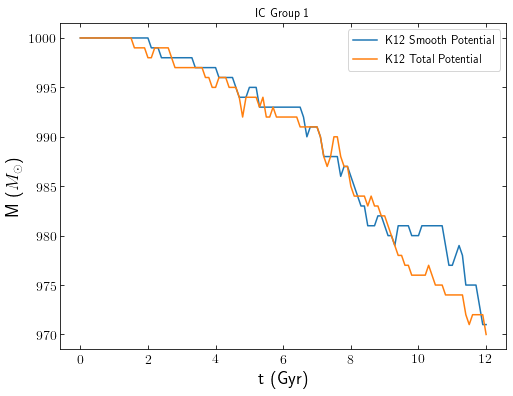

In [10]:
t = np.linspace(0,12,len(np.loadtxt(actrl_k10_fnames[0])[1]))

plt.figure(figsize=[8,6])
#plt.plot(t,np.loadtxt(actrl_k10_fnames[0])[3],label='K10')
plt.plot(t,np.loadtxt(actrl_k12_fnames[0])[2],label='K12 Smooth Potential')
plt.plot(t,np.loadtxt(actrl_k12tp_fnames[0])[2],label='K12 Total Potential')
#plt.plot(t,np.loadtxt(actrl_k13_fnames[0])[0],label='K13 Smooth')
#plt.plot(t,np.loadtxt(asub_k8_fnames[0][4])[3],label='K8 Subhalos')
#plt.plot(t,np.loadtxt(asub_k10_fnames[0])[3],label='K10 Subhalos')
#plt.plot(t,np.loadtxt(asub_k12_fnames[0])[2],label='K12 Subhalos')
#plt.plot(t,np.loadtxt(asub_k13_fnames[0])[2],label='K13 Subhalos')
#plt.plot(t[:6],np.loadtxt(asub_k14_fnames[0])[2],label='K14 Subhalos')
plt.ylabel('M ($M_{\odot}$)')
plt.xlabel('t (Gyr)')
#plt.xlim(0.19,0.205)
plt.legend()
#plt.text(0,950,'0.1\% 60kpc',fontsize=15)
plt.savefig('K12_mdif')
plt.title('IC Group 1')
plt.show()

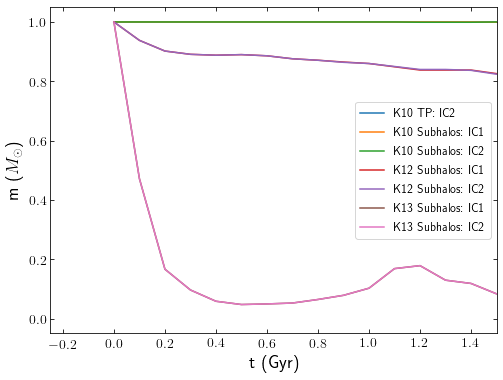

In [15]:
plt.figure(figsize=[8,6])
plt.plot(t,np.loadtxt(actrl_k10_2_fnames[0])[2]/1000,label='K10 TP: IC2')

plt.plot(t,np.loadtxt(asub_k10_fnames[0])[2]/1000,label='K10 Subhalos: IC1')
plt.plot(t,np.loadtxt(asub_k10_2_fnames[0])[2]/1000,label='K10 Subhalos: IC2')
plt.plot(t,np.loadtxt(asub_k12_fnames[0])[2]/1000,label='K12 Subhalos: IC1')
plt.plot(t,np.loadtxt(asub_k12_2_fnames[0])[2]/1000,label='K12 Subhalos: IC2')
plt.plot(t,np.loadtxt(asub_k13_fnames[0])[2]/1000,label='K13 Subhalos: IC1')
plt.plot(t,np.loadtxt(asub_k13_2_fnames[0])[2]/1000,label='K13 Subhalos: IC2')

plt.ylabel('m ($M_{\odot}$)')
plt.xlabel('t (Gyr)')
plt.xlim(-0.25,1.5)
plt.legend()
#plt.text(0,950,'0.1\% 60kpc',fontsize=15)
#plt.savefig('Kstudy')
#plt.title('IC Group 2')
plt.show()

#### 60kpc 0.1%smf Study: 2nd IC Group

### Other Tracers and Smfs: 1st IC Group

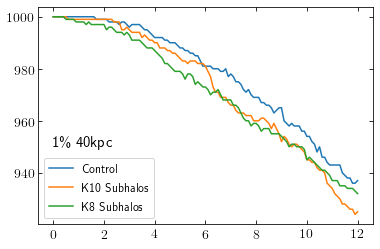

In [24]:
plt.plot(t,np.loadtxt(actrl_k10_fnames[1])[2],label='Control')
plt.plot(t,np.loadtxt(asub_k10_fnames[1])[2],label='K10 Subhalos')
plt.plot(t,np.loadtxt(asub_k8_fnames[1][3])[2],label='K8 Subhalos')
plt.legend(loc='lower left')
plt.text(0,950,'1\% 40kpc',fontsize=15)
plt.show()

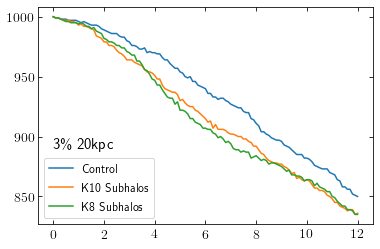

In [25]:
plt.plot(t,np.loadtxt(actrl_k10_fnames[2])[2],label='Control')
plt.plot(t,np.loadtxt(asub_k10_fnames[2])[2],label='K10 Subhalos')
plt.plot(t,np.loadtxt(asub_k8_fnames[2][2])[2],label='K8 Subhalos')
plt.legend(loc='lower left')
plt.text(0,890,'3\% 20kpc',fontsize=15)
plt.show()

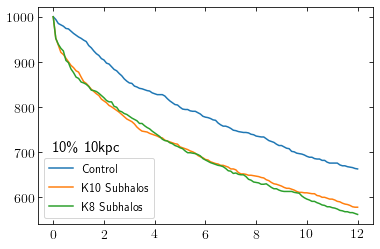

In [26]:
plt.plot(t,np.loadtxt(actrl_k10_fnames[3])[2],label='Control')
plt.plot(t,np.loadtxt(asub_k10_fnames[3])[2],label='K10 Subhalos')
plt.plot(t,np.loadtxt(asub_k8_fnames[3][1])[2],label='K8 Subhalos')
plt.legend(loc='lower left')
plt.text(0,700,'10\% 10kpc',fontsize=15)
plt.show()

### Create program to analyze for close encounters from past simulations

In [9]:
def close_encounters_apressim(smf=float,tracer_r=float or int,IC_fname=str):
    '''
    This function eats the inital coordinates of the subhalos from the raw data file and 
    uses them in its analysis instead of a randomly generated set.
    '''
    
    # set the substructure mass fraction
    smf = smf
    
    # potential creation (total,smooth,clumpy)
    tp = gp.potential.LogarithmicHaloPotential(amp=1., ro=ro,vo=vo)
    sp = gp.potential.LogarithmicHaloPotential(amp=1.-smf, ro=ro,vo=vo)
    cp = gp.potential.LogarithmicHaloPotential(amp=smf, ro=ro,vo=vo)
    
    # radius and mass at each radius in each potential
    r=np.linspace(0,100.,5000)
    tmar = []
    smar = []
    cmar = []
    for i in r:
        tmar.append(tp.mass(i/ro))
        smar.append(sp.mass(i/ro))
        cmar.append(cp.mass(i/ro))
    
    # initialize the tracer orbit as circular in the smooth potential (total - sub potential)
    if type(tracer_r)==int or type(tracer_r)==float:
        tracer_r=[tracer_r]

    # set up an orbit for the tracer
    tracer_r = np.array(tracer_r)
    tracer_cv = sp.vcirc(tracer_r)
    tracer_zeros = np.zeros(len(tracer_r))
    tracerorb = np.column_stack([tracer_r/ro,tracer_zeros,tracer_cv/vo,tracer_zeros,tracer_zeros,tracer_zeros])

    # get all ICs from past simuilation
    all_ICs = np.loadtxt(IC_fname,unpack=True)
    
    # parse IC list for ms, positions, velocities 
    sh_ms = all_ICs[0][1000:]
    sh_xs = all_ICs[1][1000:]
    sh_ys = all_ICs[2][1000:]
    sh_zs = all_ICs[3][1000:]
    sh_vxs = all_ICs[4][1000:]
    sh_vys = all_ICs[5][1000:]
    sh_vzs = all_ICs[6][1000:]
    
    # transform from cartesian to cylindrical
    sh_rs, sh_phis, sh_zs = gp.util.bovy_coords.rect_to_cyl(sh_xs,sh_ys,sh_zs)
    sh_vrs, sh_vts, sh_vzs = gp.util.bovy_coords.rect_to_cyl_vec(sh_vxs,sh_vys,sh_vzs,sh_xs,sh_ys,sh_zs) 
    
    # initialize and integrate the subhalo's orbits in the total potential
    shorb = np.column_stack([sh_rs/ro,sh_vrs/vo,sh_vts/vo,sh_zs/ro,sh_vzs/vo,sh_phis])
    sh_orbits = gp.orbit.Orbit(shorb,ro=ro,vo=vo)
    sh_orbits.integrate(torb/to,tp)
    
    #initialize the hernquist potentials for the subhalos
    sh_hern_r=[]
    for i in sh_ms:
        sh_hern_r.append(1.05*(i/(10**(8)))**(0.5))
    sh_pots=[]
    for i in range(len(sh_ms)):
        sh_pots.append(gp.potential.HernquistPotential(sh_ms[i]/mo,sh_hern_r[i]/ro,ro=ro,vo=vo))
    
    #create the moving potential
    moving_potential=[]
    for i in range(len(sh_orbits)):
        moving_potential.append(gp.potential.MovingObjectPotential(sh_orbits[i],sh_pots[i]))
    moving_potential.append(sp)

    #integrate the tracer orbit in the moving potential
    tracer_orbit_subs = gp.orbit.Orbit(tracerorb,ro=ro,vo=vo)
    tracer_orbit_subs.integrate(torb/to,moving_potential)
    
    # redefine variables cause I'm lazy
    sh_orbs = sh_orbits

    # determine how many close encounters it has with the four subhalo mass classes (1e6-1e7, 1e7-1e8, 1e8-1e8.5, 1e8.5-1e9) over its evolution
    
    # define lists to hold the number of subhalos / mass for every scenario
    total_subs = [ [], [], [], [] ]
    encounters = [ [], [], [], [] ]
    
    # get positions
    tracer_x, tracer_y, tracer_z = tracer_orbit_subs.x(torb[:]/to)[:], tracer_orbit_subs.y(torb[:]/to)[:], tracer_orbit_subs.z(torb[:]/to)[:]
    sub_xs, sub_ys, sub_zs = sh_orbs.x(torb[:]/to)[:], sh_orbs.y(torb[:]/to)[:], sh_orbs.z(torb[:]/to)[:]

    # subtract the positions and sort to find the closeset subhalo at each timestep
    
    # tracer_x is /1000 for units: sub_xs is naturally in kpc, tracer_x is naturally in pc
    sub_tracer_separations = np.sqrt( (sub_xs - tracer_x)**2 + (sub_ys - tracer_y)**2  + (sub_zs - tracer_z)**2 )
    
    # get the closest sub at each timestep
    closest_subs = np.argsort(sub_tracer_separations,axis=0)[0]        
    
    
    #
    close_subs = []
    
    
    # make a plot of the closest subhalo vs time
    closest_distances = []
    for i in range(len(torb)):
        close_sub_index = closest_subs[i]
        close_subs.append(close_sub_index)
        closest_distances.append(sub_tracer_separations[close_sub_index][i])
       
    plt.plot(torb,closest_distances)
    plt.show()

    # set an encounter distance
    encounter_distance = 1

    # this loop looks at each timestep for the array of subhalo-tracer separations for each subhalo, and appends the mass of the subhalo that is below the encounter distance
    close_encounters_masses = []
    for j in range(len(sub_tracer_separations)):
        for k in range(len(torb)):
            if sub_tracer_separations[j][k] < encounter_distance:
                close_encounters_masses.append(sh_ms[j])
            else:
                continue

    # the below loops determine the number of encounters by mass range
    ten6s = 0
    ten7s = 0
    low_ten8s = 0
    high_ten8s = 0

    for m in np.log10(close_encounters_masses):
        if m < 7:
            ten6s += 1
        elif m > 7 and m < 8:
            ten7s += 1
        elif m > 8 and m < 8.5:
            low_ten8s += 1
        elif m > 8.5:
            high_ten8s += 1

    # append encoutners to output list, separated by tracer (t) and mass range for each tracer (m) [t][m]
    encounters[0].append(ten6s)
    encounters[1].append(ten7s)
    encounters[2].append(low_ten8s)
    encounters[3].append(high_ten8s)
            
        
    return closest_distances, encounters, tracer_orbit_subs, sh_orbs, close_subs, total_subs, sh_ms
    #np.savetxt(str(int(smf*100)) + 'smf_total_subs.dat',total_subs)
    #np.savetxt(str(int(smf*100)) + 'smf_5kpc_encounters.dat',encounters[0])
    #np.savetxt(str(int(smf*100)) + 'smf_10kpc_encounters.dat',encounters[1])
    #np.savetxt(str(int(smf*100)) + 'smf_20kpc_encounters.dat',encounters[2])
    #np.savetxt(str(int(smf*100)) + 'smf_40kpc_encounters.dat',encounters[3])
    #np.savetxt(str(int(smf*100)) + 'smf_60kpc_encounters.dat',encounters[4])

In [11]:
# GALPY scaling variables
ro=8.
vo=220.
to=gp.util.bovy_conversion.time_in_Gyr(ro=ro,vo=vo)
mo=gp.util.bovy_conversion.mass_in_msol(ro=ro,vo=vo)

#integration time
torb = np.linspace(0,12.,120000)

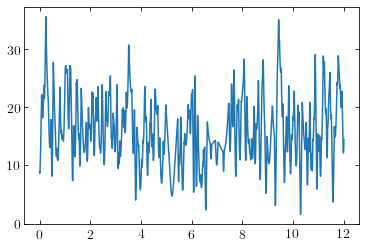

192.9075379371643 seconds


In [12]:
t0 = time()

close_sub_v_time, sub_encounters, tracer_orb, sh_orbs, close_subs, total_subs, sh_masses  = close_encounters_apressim(smf=0.001,tracer_r=60,IC_fname='kmax12/ptrb_IC_60kpc_0smf_mspec_1000stars.dat')

print(str(time()-t0) + ' seconds')

KeyboardInterrupt: 

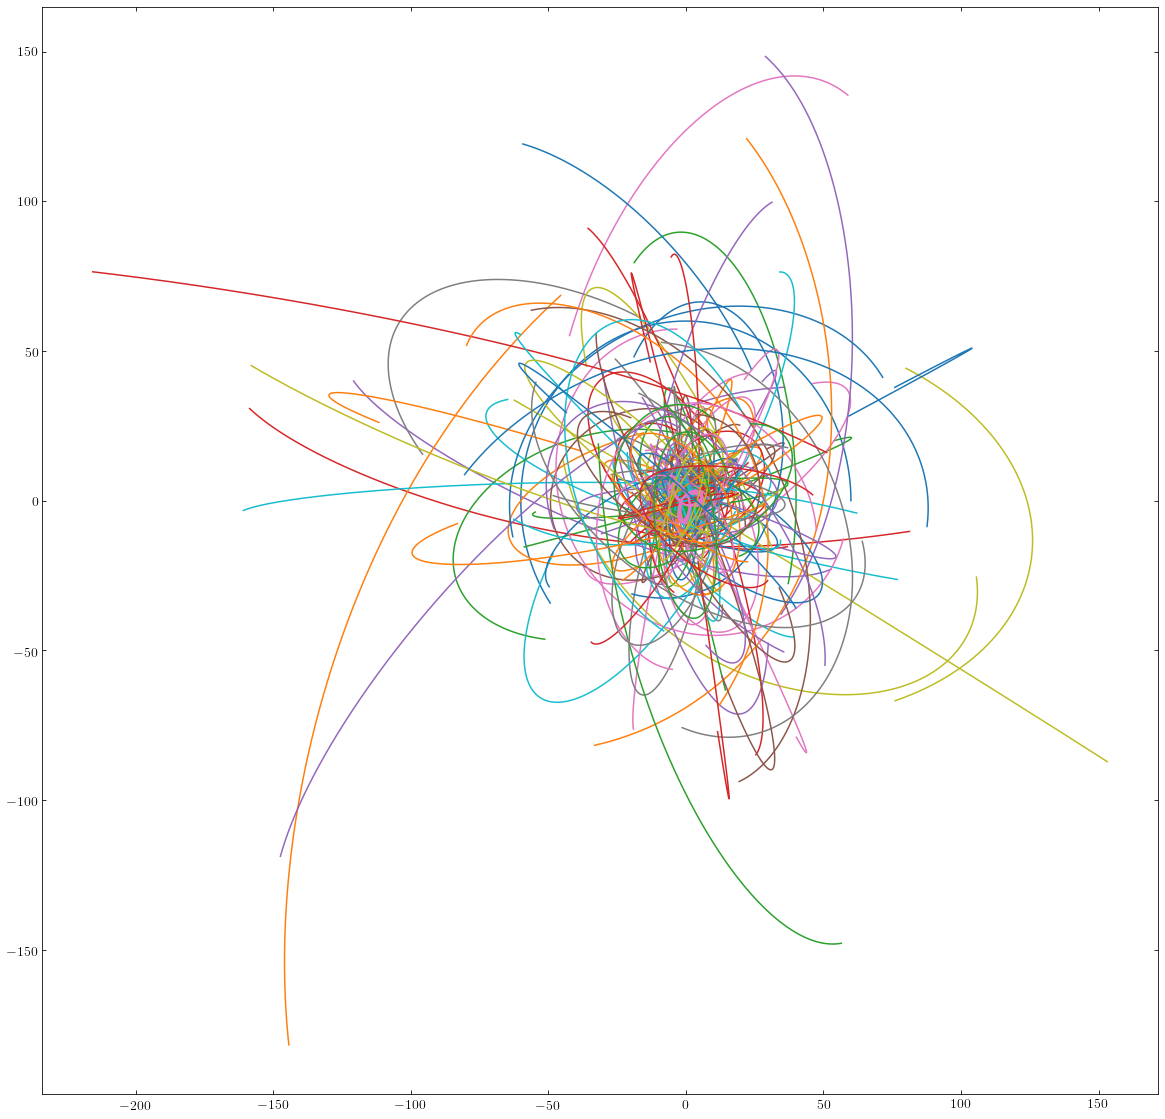

In [13]:
plt.figure(figsize=[20,20])
plt.plot(tracer_orb.x(torb[:10000]/to)[0],tracer_orb.y(torb[:10000]/to)[0])
for i in range(len(sh_orbs)):
    plt.plot(sh_orbs.x(torb[:10000]/to)[i],sh_orbs.y(torb[:10000]/to)[i])
#plt.legend()
plt.axis('off')
plt.savefig('orbits.png')
plt.show()

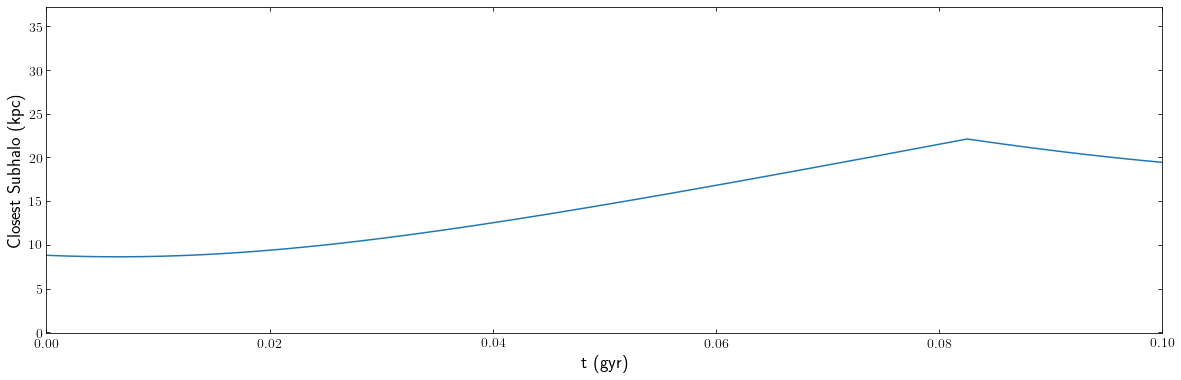

In [71]:
plt.figure(figsize=[20,6])
plt.plot(torb,close_sub_v_time)
plt.xlabel('t (gyr)')
plt.ylabel('Closest Subhalo (kpc)')
plt.xlim(0,0.1)
plt.show()

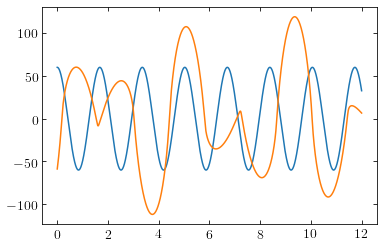

In [72]:
plt.plot(torb,tracer_orb.x(torb[:]/to)[0])
plt.plot(torb,sh_orbs.x(torb[:]/to)[1])

In [73]:
from collections import Counter

In [74]:
occurances_dict = Counter(close_subs)

In [75]:
occurances = []
sub_number = []
for i in range(300):
    if occurances_dict[i] == 0:
        continue
    else:
        sub_number.append(i)
        occurances.append(occurances_dict[i])

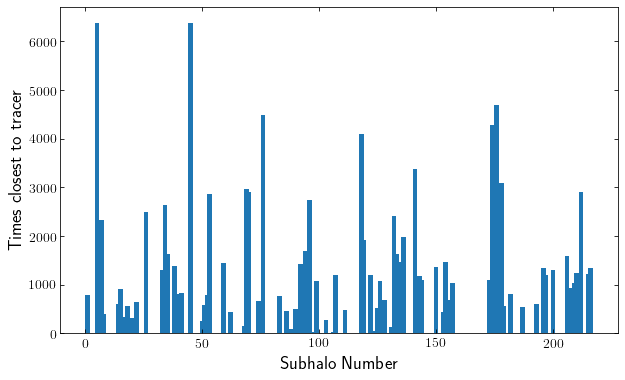

In [76]:
plt.figure(figsize=[10,6])
plt.bar(sub_number,occurances,width = 2)
plt.xlabel('Subhalo Number')
plt.ylabel('Times closest to tracer')
plt.show()

In [77]:
total_subs

[[], [], [], []]

In [14]:
5+5

10

In [18]:
np.loadtxt(asub_k10_fnames[0])[1][0]

2.9572433120580377

In [18]:
test = np.loadtxt('kmax14/ptrb_EV_60kpc_1000stars.dat')

OSError: kmax14/ptrb_EV_60kpc_1000stars.dat not found.